<style type="text/css">.tg  {border-collapse:collapse;border-spacing:0;}.tg td{border-color:rgb(16, 137, 182);border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;word-break:normal;}.tg th{border-color:rgb(16, 137, 182);border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}.tg .tg-73oq{border-color:rgb(10, 89, 162);text-align:left;vertical-align:middle}.tg .tg-42lt{border-color:rgb(10, 89, 162);text-align:center;vertical-align:middle}.tg .tg-5qt9{font-size:small;text-align:left;vertical-align:middle}</style><table class="tg"><thead>  <tr>    <th class="tg-73oq"><img src="https://raw.githubusercontent.com/euroargodev/argopy/master/docs/_static/argopy_logo_long.png" alt="Argopy logo" width="120" height="60"></th>    <th class='tg-42lt'><h1>Compute your own per-profile diagnostic</h1></th>  </tr></thead><tbody>  <tr>    <td class="tg-5qt9" colspan="2"><span style="font-weight:bold">Author :</span> <a href="//annuaire.ifremer.fr/cv/17182" target="_blank" rel="noopener noreferrer">G. Maze</a></td>  </tr>  <tr>    <td class="tg-5qt9" colspan="2">🏷️ This notebook is compatible with Argopy versions &gt;= <a href="https://argopy.readthedocs.io/en/v1.3.1" target="_blank" rel="noopener noreferrer">v1.3.1</a></td>  </tr>  <tr>    <td class="tg-5qt9" colspan="2">© <a href="https://github.com/euroargodev/argopy-training/blob/main/LICENSE" target="_blank" rel="noopener noreferrer">European Union Public Licence (EUPL) v1.2</a>, see at the bottom of this notebook for more.</td>  </tr></tbody></table>
**Description:**

This notebook shows how to complement an existing Argo data dataset with your own per-profile diagnostic.

The [Dataset.argo.reduce_profile() (↗)](https://argopy.readthedocs.io/en/v1.3.1/generated/xarray.Dataset.argo.reduce_profile.html#xarray.Dataset.argo.reduce_profile) method allows to execute a per profile diagnostic function very efficiently. 

Such a diagnostic function **takes vertical profiles as input and return a single value as output** (see examples below). Typical usage example would include computation of mixed layer depth or euphotic layer depth.

This is a notebook exploring this [section of the Argopy documentation (↗)](https://argopy.readthedocs.io/en/v1.3.1/user-guide/working-with-argo-data/data_computation.html#per-profile-custom-diagnostic).


**Table of Contents**
- [Execute a diagnostic without options](#execute-a-diagnostic-without-options)
    - [🛟 Note](#🛟-note)
    - [🔍 Pro tip](#🔍-pro-tip)
    - [✏️ EXERCISE](#✏️-exercise)
- [Execute a diagnostic with options](#execute-a-diagnostic-with-options)
    - [🔍 Pro tip](#🔍-pro-tip)
    - [✏️ EXERCISE](#✏️-exercise)
- [Optimise slow diagnostics with Dask](#optimise-slow-diagnostics-with-dask)
***

Let's start with some import:

In [1]:
from argopy import DataFetcher
import numpy as np

And to prevent cell output to be too large, we won't display xarray object attributes:

In [2]:
import xarray as xr
xr.set_options(display_expand_attrs = False)

## Execute a diagnostic without options

The most simple example is when the diagnostic method does not need arguments.

To illustrate this, let's apply a diagnostic that computes the mixed layer depth for a profile.

🛟 It is important to note that the per-profile diagnostic will receive 1-dimensional arrays of one profile data, not xarray object. 

Such a diagnostic could be written as:

In [3]:
def diag_mld(pres, sig0):
    """Return MLD with Boyer Montégut method with threshold of σ(10m) + 0.03 kg.m-3"""
    # Reference values
    threshold, threshold_depth = 0.03, 10.
    
    # Filter out NaN values
    idx = ~np.logical_or(np.isnan(pres), np.isnan(sig0))
    sig0_depth, sig0 = pres[idx], sig0[idx]

    # Check if there are valid data points near the reference depth
    if not np.any((sig0_depth >= 0) & (sig0_depth <= threshold_depth)):
        return np.nan

    # Get the reference density at the threshold depth
    index_threshold = np.argmin(np.abs(sig0_depth - threshold_depth))
    sig0_at_threshold = sig0[index_threshold]

    # Find the first depth where density exceeds the threshold
    exceeds_threshold = sig0[index_threshold:] > sig0_at_threshold + threshold
    if not np.any(exceeds_threshold):
        return np.nan

    mld_index = np.where(exceeds_threshold)[0][0] + index_threshold
    return sig0_depth[mld_index]

Then to apply the diagnostic to a collection of Argo profiles, let's first load data from a region just South of the Gulf Stream:

In [4]:
%%time
f = DataFetcher().region([-69., -64., 32., 36., 0., 1000., '20200101', '20230101'])
ds = f.data
ds.argo

CPU times: user 15.9 s, sys: 793 ms, total: 16.6 s
Wall time: 32.7 s


<xarray.Dataset.argo>
This is a collection of Argo points
N_POINTS(142987) ~ N_PROF(326) x N_LEVELS(650)

<br>

and convert this collection of points to a collection of profiles:

In [5]:
dsp = ds.argo.point2profile()
dsp.argo

<xarray.Dataset.argo>
This is a collection of Argo profiles
N_PROF(326) x N_LEVELS(650) ~ N_POINTS(211900)

<br>

We note that the `diag_mld` method above, takes pressure and potential density as arguments, in this order.

Argopy and xarray will handle all the axis and dimensions manipulation, so that you can focus on writing a reducer function dealing with 1D arrays for each requested parameters.

So, to apply this diagnostic to the xarray Argo dataset, we first need to compute SIG0 and then we can call the reducer:

In [6]:
%%time
dsp.argo.teos10(['SIG0']);

CPU times: user 1.08 s, sys: 4 ms, total: 1.08 s
Wall time: 1.08 s


In [7]:
%%time
dsp['MLD'] = dsp.argo.reduce_profile(diag_mld, params=['PRES', 'SIG0'])
dsp['MLD']

CPU times: user 6.5 ms, sys: 25 μs, total: 6.52 ms
Wall time: 6.41 ms


<xarray.DataArray 'MLD' (N_PROF: 326)> Size: 1kB
array([149.7 , 164.7 ,  82.  , 156.9 , 187.3 , 148.  , 172.1 , 211.9 ,
       143.2 , 157.1 , 154.6 ,  80.6 , 107.2 ,  43.6 ,  18.7 , 181.7 ,
        78.  , 107.2 , 182.2 ,  91.96, 176.04, 154.9 ,  81.4 ,  41.96,
       149.96,  88.9 ,  66.5 , 195.96, 169.96,  30.8 ,  46.  ,  49.5 ,
        38.  ,  79.96,  41.9 ,  32.04,  18.  ,  53.5 ,  37.96,  13.96,
        20.  ,  24.  ,  24.  ,  26.  ,  12.04,  14.  ,  11.96,  12.08,
        12.04,  13.96,  16.  ,  16.04,  14.  ,  11.96,  11.  ,  12.  ,
        18.  ,  13.96,  14.  ,  18.  ,  17.96,  22.  ,  20.  ,  18.  ,
        12.5 ,  20.08,  18.04,  22.  ,  30.04,  11.96,  13.96,  36.04,
        50.  ,  40.04,  35.  ,  56.  ,  54.96,  55.  ,  57.96,  65.8 ,
        45.  ,  75.  ,  63.96,  85.9 ,  76.  ,  74.  ,  95.1 ,  92.12,
       105.  ,  90.  ,  72.  , 107.88,  95.  ,  95.  , 128.  , 101.96,
       100.  , 106.  , 135.92, 124.  ,  85.  , 126.04,  81.  , 125.  ,
       153.96, 172.08, 116.  , 152.  , 180.  ,  95.  , 152.04, 195.92,
       258.04, 195.  , 100.  , 222.08, 264.24,  82.  , 116.  , 255.92,
       320.08,  35.  ,  59.96,  55.  ,  78.  ,    nan, 313.  , 158.  ,
          nan, 338.1 ,  41.92,    nan, 158.  ,  22.  ,  35.2 ,    nan,
        97.96, 105.2 ,    nan,  18.  ,  45.7 ,  18.  ,    nan,  58.08,
        45.2 ,  42.  ,  46.04,  17.88,  25.  ,  29.96,  28.04,  40.26,
        26.  ,  35.4 ,  16.  ,  11.96,  15.  ,  17.96,  12.08,  15.  ,
...
        22.  ,  13.92,  14.  ,  11.92,  15.  ,  36.  ,  26.  ,  55.  ,
        24.  ,  24.12,  16.12,  33.8 ,  39.92,  26.  ,  14.04,  21.92,
        46.  ,  28.  ,  41.96,  29.92,  45.  ,  72.3 ,  54.12,  90.  ,
        55.  ,  82.9 ,  51.92,  67.92,  46.  ,  97.92,  80.  ,  65.  ,
       126.  ,  39.96,  70.  , 107.  ,  91.96,  68.  ,  94.  , 108.1 ,
        92.04,  41.96,  89.92, 116.08,  83.96, 120.04, 115.96, 165.96,
       137.96, 109.92, 160.5 , 123.96,    nan, 137.  , 140.  , 150.  ,
       136.  , 155.  , 134.04,  97.75,  18.  ,  72.3 , 115.64, 142.05,
       152.04, 175.92,  18.26, 149.67, 190.04,  46.  , 150.06,  53.91,
       167.96, 168.01,  86.19,  86.  ,  71.96,  65.96, 161.85,  86.02,
        29.92,  23.82,  30.  ,  39.95,  19.89,  13.77,  12.  ,  14.51,
        25.93,  36.55,  11.96,  20.31,  11.93,  11.91,  16.  ,  14.21,
        11.86,  14.8 ,  11.96,  21.52,  13.9 ,  22.04,  24.35,  17.96,
        25.79,  20.  ,  25.  ,  21.97,  16.04,  40.  ,  34.1 ,  31.69,
        32.31,  15.  ,  22.  ,  25.1 ,  12.3 ,  13.95,  15.3 ,  28.8 ,
        54.26,  76.09,  45.1 ,  37.  ,  32.09,  65.84,  43.9 ,  46.1 ,
        64.04,  65.86,  78.  ,  66.9 ,  68.9 ,  93.88,  66.04,  37.95,
        66.24,  63.1 , 113.96,  72.  ,  79.89,  78.22, 136.  ,  78.9 ,
        66.  , 130.04, 115.93, 100.4 , 119.  , 119.96, 118.04, 115.96,
        99.37, 156.9 , 139.92, 126.08, 141.72, 164.2 ], dtype=float32)
Coordinates:
  * N_PROF     (N_PROF) int64 3kB 32 68 98 33 69 99 ... 314 131 120 315 308 132
    LATITUDE   (N_PROF) float64 3kB 33.04 34.64 32.06 ... 33.35 34.23 34.92
    LONGITUDE  (N_PROF) float64 3kB -68.7 -68.68 -67.9 ... -66.46 -68.76 -66.48
    TIME       (N_PROF) datetime64[ns] 3kB 2020-01-02T11:41:30 ... 2022-12-30...
Attributes: (8)

#### 🛟 Note

Note that the new variable has the appropriate dimension `N_PROF` and coordinates.


#### 🔍 Pro tip

You can add attributes to the new variable and you can plot it along the dataset potential density like this:

(easier methods shall be developped in the future)

In [8]:
dsp['MLD'].attrs = {'unit': 'db',
                   'long_name': 'Mixed Layer Depth',
                   'method': 'Density threshold'}

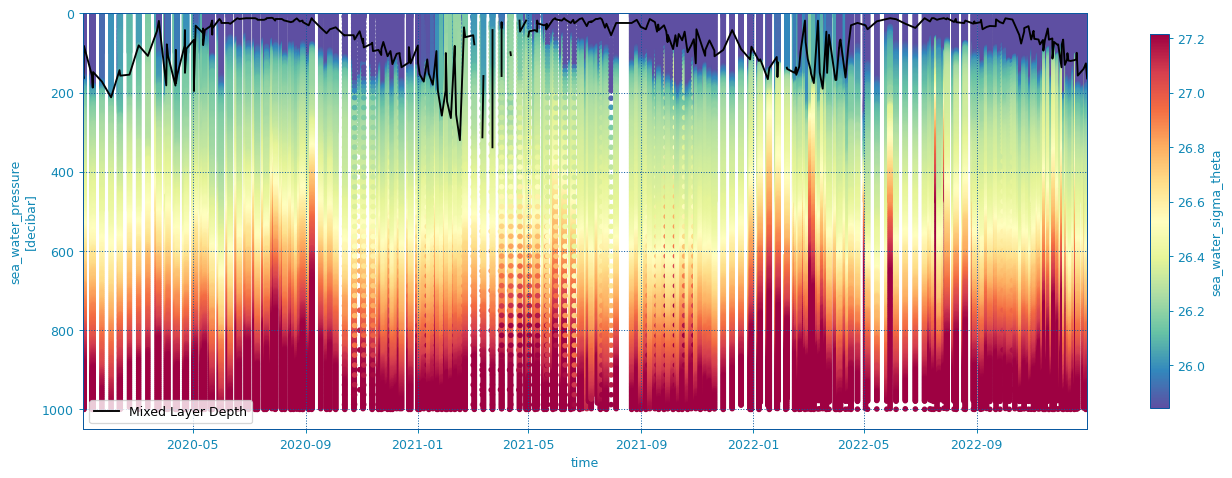

In [9]:
from argopy.plot import scatter_plot
import matplotlib.pyplot as plt

fig, ax, _, _ = scatter_plot(dsp, 'SIG0', cmap='Spectral_r', s=12, cbar=True);
ax.plot(dsp['TIME'], dsp['MLD'], 'k', label=dsp['MLD'].attrs['long_name'])
ax.legend(loc='lower left');

#### ✏️ EXERCISE

Write down a function computing the oxygen minimum depth and apply it to some BGC-Argo dataset.

💡 Code hint: 
```python
def min_oxygen_depth(pres, doxy):    
    idx = ~np.logical_or(np.isnan(pres), np.isnan(doxy))  # Filter out NaN values
    return ...

f = DataFetcher(ds='bgc', params='DOXY').float(6903222)
dsp = f.data.argo.point2profile()
dsp...
```

In [10]:
# Your code here

## Execute a diagnostic with options

In a more realistic scenario, it will often be the case that your diagnostic will require options to play around with some parameters.

**To add options to your diagnostic, just add them as named arguments to the method and provide them to the Argopy reducer.**

To illustrate this, let's take a diagnostic method that computes the depth of an isothermal surface, which should be given as an option.

It could go like this:

In [11]:
def isoT_depth(pres, temp, iso = 12.):
    idx = ~np.logical_or(np.isnan(pres), np.isnan(temp))
    idx_top, idx_btm = temp[idx] >= iso, temp[idx] <= iso
    if np.any(idx_top):
        i_top, i_btm = np.max(np.argwhere(idx_top)), np.min(np.argwhere(idx_btm))
        t_top, p_top, t_btm, p_btm = temp[i_top], pres[i_top], temp[i_btm], pres[i_btm]
        return p_top + (p_btm-p_top)*(t_top-isotemp)/(t_top-t_btm)
    return np.nan

<br>

Let's download and transform some float data to illustrate this diagnostic:

In [12]:
%%time
f = DataFetcher().float(6902915)  # A float in the North Atlantic subtropical gyre
dsp = f.data.argo.point2profile()
dsp.argo

CPU times: user 13 s, sys: 828 ms, total: 13.8 s
Wall time: 21.6 s


<xarray.Dataset.argo>
This is a collection of Argo profiles
N_PROF(246) x N_LEVELS(1024) ~ N_POINTS(251904)

<br>

Let's now apply the diagnostic:

In [13]:
isotemp = 26.  # Isothermal surface target, in degree Celsius

da = dsp.argo.reduce_profile(isoT_depth, params=['PRES', 'TEMP'], iso=isotemp)
da.attrs = {'unit': 'db',
            'long_name': f"TEMP={isotemp}^oC depth"}

/tmp/ipykernel_646326/1990919006.py:7: RuntimeWarning: invalid value encountered in scalar divide
  return p_top + (p_btm-p_top)*(t_top-isotemp)/(t_top-t_btm)


<br>

Add the new variable to the Argo dataset:

In [14]:
dsp['isoT'] = da

#### 🔍 Pro tip

You can plot the new variable like this:

(easier methods shall be developped in the future)

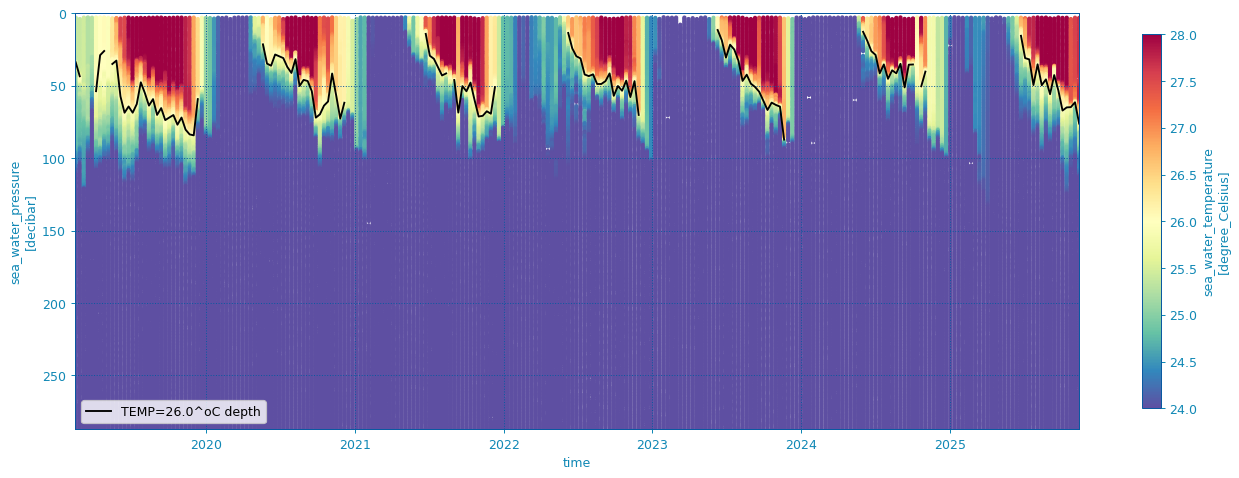

In [15]:
from argopy.plot import scatter_plot
import matplotlib.pyplot as plt

fig, ax, _, _ = scatter_plot(dsp, 'TEMP', cmap='Spectral_r', s=6, vmin=isotemp-2, vmax=isotemp+2, cbar=1);
ax.plot(dsp['TIME'], dsp['isoT'], 'k', label=dsp['isoT'].attrs['long_name'])
ax.set_ylim([np.nanmax(dsp['isoT'])+200, 0])
ax.legend(loc='lower left');

#### ✏️ EXERCISE

Getting back to the mixed layer depth diagnostic, the density reference level and threshold could be options easily accessible for a more appropriate diagnostic.

Modify the `diag_mld` method to take reference values as option and demonstrate its use.

In [16]:
# Your code here

## Optimise slow diagnostics with Dask

Using a [Dask cluster (↗)](https://docs.dask.org/en/stable/deploying.html), chunking your dataset along the `N_PROF` dimension will make Argopy and xarray to execute the diagnostic on each chunk of profile in parallel.

🔍 In particular, if your diagnostic is rather slow to execute on a single profile, you can optimise the execution on making chunks rather small, i.e. with a small amount of profiles.

To illustrate this, let's first create a simple local Dask cluster:

In [ ]:
from dask.distributed import Client
client = Client()
client

<br>

Download some dataset:

In [ ]:
f = DataFetcher().float(6902915)  # A float in the North Atlantic subtropical gyre
dsp = f.data.argo.point2profile()
dsp.argo

<br>

and to trigger parallelisation, we also chunk the dataset:

In [ ]:
chunk_size = 10  # Nb of profiles per chunk
dsp = dsp.chunk({'N_PROF': chunk_size})
dsp['PRES'].data  # To visualise chunking on a dataarray

<br>

We now create a dummy diagnostic, that will artificially be long to execute with a time sleep:

In [ ]:
import time

def dummy(pres, temp, wait=1.):
    time.sleep(wait)
    return temp[0]

<br>

Execute the diagnostic and look at the Dask client dashboard to monitor the parallelisation.

In [ ]:
%%time
wait = 0.3  # per-profile waiting time, in seconds
dsp.argo.reduce_profile(dummy, params=['PRES', 'TEMP'], wait=wait).compute();

In [ ]:
# In parallel, each chunk of profiles will need about:
chunk_size * wait  # seconds to execute

In [ ]:
# Since the number of streams that will receive the flow of chunks is:
n_stream = sum([value for key, value in client.nthreads().items()])

# Each stream will thus receive about p chunks:
p = len(dsp['PRES'].chunks[0])/n_stream

# So each stream should last about, an indication of the overall execution time in parallel:
chunk_size * wait * p

<br>

If the diagnostic was executed sequentially, we would need to wait at least `N_PROF x wait` seconds:

In [ ]:
len(dsp['N_PROF']) * wait

<br>

So let's check this and execute the diagnostic sequentially on all profiles:

In [ ]:
# Remove chunking:
dsp = dsp.compute()

In [ ]:
%%time
dsp.argo.reduce_profile(dummy, params=['PRES', 'TEMP'], wait=wait);

<br>

Finaly shut down the Dask client:

In [ ]:
client.close()


## 🏁 End of the notebook

***
#### 👀 Useful argopy commands
```python
argopy.reset_options()
argopy.show_options()
argopy.status()
argopy.clear_cache()
argopy.show_versions()
```
#### ⚖️ License Information
This Jupyter Notebook is licensed under the **European Union Public Licence (EUPL) v1.2**.

| Permissions      | Limitations     | Conditions                     |
|------------------|-----------------|--------------------------------|
| ✔ Commercial use | ❌ Liability     | ⓘ License and copyright notice |
| ✔ Modification   | ❌ Trademark use | ⓘ Disclose source              |
| ✔ Distribution   | ❌ Warranty      | ⓘ State changes                |
| ✔ Patent use     |                  | ⓘ Network use is distribution  |
| ✔ Private use    |                  | ⓘ Same license                 |

For more details, visit: [EUPL v1.2 Full Text (↗)](https://github.com/euroargodev/argopy-training/blob/main/LICENSE).

#### 🤝 Sponsor
![logo (↗)](https://raw.githubusercontent.com/euroargodev/argopy-training/refs/heads/main/for_nb_producers/disclaimer_argopy_EAONE.png)
***
